In [1]:
from encoded_protein_dataset import EncodedProteinDataset, collate_fn, get_embedding, dynamic_collate_fn, collate_fn2
from pseudolikelihood import get_npll
import torch
import numpy as np
from potts_decoder import PottsDecoder
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.tensorboard import SummaryWriter
from functools import partial
from tqdm import tqdm
import os
#import pandas as pd
import csv
from torch.autograd import profiler 

/Data/silva/miniconda3/envs/InvFolding/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def check_gpu_mem():
    '''
    Uses Nvidia's SMI tool to check the current GPU memory usage.
    '''
    
    # Run the command line tool and get the results.
    buf = os.popen('nvidia-smi --query-gpu=memory.total,memory.used --format=csv')

    # Use csv module to read and parse the result.
    reader = csv.reader(buf, delimiter=',')

    # Use a pandas table just for nice formatting.
    df = pd.DataFrame(reader)

    # Use the first row as the column headers.
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header

    # Display the formatted table.
    #display(df)

    return df

# Data loading

In [2]:
## The max_msas optional parameter in the EncodedProteinDataset library allows to select just a subset of the folders of that size 
### Takes roughly 35 minutes... sometimes 4... makes no sense...
##lenght of training data should be 22559
train_dataset = EncodedProteinDataset('/Data/InverseFoldingData/msas/train', '/Data/InverseFoldingData/structure_encodings', max_msas=100, noise=0.02)
sequence_test_dataset = EncodedProteinDataset('/Data/InverseFoldingData/msas/test/sequence', '/Data/InverseFoldingData/structure_encodings', max_msas=100)
structure_test_dataset = EncodedProteinDataset('/Data/InverseFoldingData/msas/test/structure', '/Data/InverseFoldingData/structure_encodings', max_msas=100)
superfamily_test_dataset = EncodedProteinDataset('/Data/InverseFoldingData/msas/test/superfamily', '/Data/InverseFoldingData/structure_encodings', max_msas=100)


/home/silval/InverseFolding/InverseFolding_git/encoded_protein_dataset.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encodings = torch.tensor(read_encodings(encoding_path, trim=False))


In [4]:
len(train_dataset)

2725

In [4]:
import matplotlib.pyplot as plt
lens = torch.zeros(len(train_dataset))
idx=0
for msa, encoding in train_dataset:
    lens[idx] = msa.shape[1]
    idx+=1



tensor(938.)


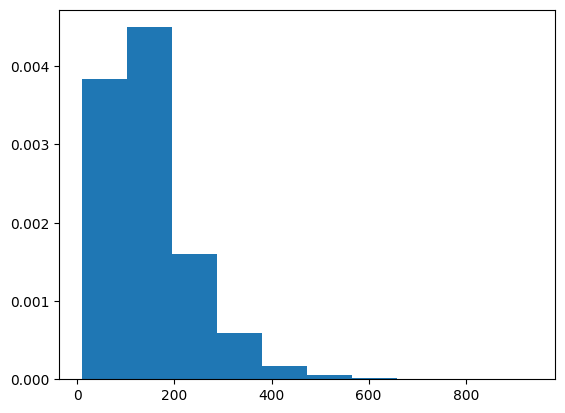

In [13]:
plt.hist(lens, density=True);
print(lens.max())

In [3]:
batch_structure_size = 4   ### I think with empty GPU we can go up to 10
perc_subset_test = 0.1     ## During the training, for every dataset available we select a random 10% of its samples
batch_msa_size = 16
q = 21 ##isn't always 21
collate_fn = partial(collate_fn, q=q, batch_msa_size=batch_msa_size)
train_loader = DataLoader(train_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=True)
#sequence_test_loader = DataLoader(sequence_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn)
#structure_test_loader = DataLoader(structure_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn)
#superfamily_test_loader = DataLoader(superfamily_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn)


sequence_test_loader = DataLoader(sequence_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
sampler=RandomSampler(sequence_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(sequence_test_dataset))))

structure_test_loader = DataLoader(structure_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
sampler=RandomSampler(structure_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(structure_test_dataset))))

superfamily_test_loader = DataLoader(superfamily_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
sampler=RandomSampler(superfamily_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(superfamily_test_dataset))))

In [10]:
for el in train_loader:
    el

In [13]:
el[2].shape

torch.Size([4, 119])

## CODE PROFILING

In [13]:
df = check_gpu_mem()

In [24]:
int(df.values[1, 1][1:-4])

5440

In [12]:
reader.

AttributeError: '_csv.reader' object has no attribute 'read'

In [6]:
decoder = None
embedding = None
torch.cuda.empty_cache()

input_encoding_dim = train_dataset.encoding_dim
param_embed_dim = 512
n_param_heads = 4
d_model = 128
n_heads = 2
n_layers = 2
## Check before running which is the GPU which is free the most and put it as the running device
device = 1
eta = 1e-3
dropout = 0.0




with profiler.profile(with_stack=True, profile_memory=True, record_shapes=True) as prof:
    with profiler.record_function("Sending model and embeddings to GPU"):
        decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout)
        batch = next(iter(train_loader))
        decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout)
        decoder.to(device)
        embedding = get_embedding(q)
        embedding.to(device)

    with profiler.record_function("Sending data to GPU"):
        msas, encodings, padding_mask  = [input.to(device) for input in batch]
        B, M, N = msas.shape
        #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    with profiler.record_function("Forward pass"):
        couplings, fields = decoder(encodings, padding_mask)
        
#print(prof.key_averages(group_by_stack_n=5))

In [15]:
def get_loss(decoder, inputs, eta):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input.to(device) for input in inputs]
    B, M, N = msas.shape
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    couplings, fields = decoder(encodings, padding_mask)

    # embed and reshape to (B, M, N*q)
    msas_embedded = embedding(msas).view(B, M, -1)

    # get npll
    npll = get_npll(msas_embedded, couplings, fields, N, q)


    padding_mask_inv = (~padding_mask)

    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    penalty = eta*(torch.sum(couplings**2) + torch.sum(fields**2))/B

    # the padding mask does not contain the msa dimension so we need to multiply by M
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    loss_penalty = npll_mean  + penalty

    return loss_penalty, npll_mean.item()  ##we can just add the penalty since we have set already to 0 couplings and fields of padded elements



def get_loss_loader(decoder, loader, eta):

    decoder.eval()
    losses = []
    with torch.no_grad():
        for inputs in loader:
            loss, npll = get_loss(decoder, inputs, eta) 
            losses.append(npll)
    
    return np.mean(losses)

## Profiling backward pass

In [18]:
optimizer = torch.optim.Adam(decoder.parameters(), lr=0.0001)
decoder.train()
with profiler.profile(with_stack=True, profile_memory=True, record_shapes=True) as prof:
    with profiler.record_function("Computing the loss"):
        loss_penalty, train_batch_loss = get_loss(decoder, batch, eta)    ## get the current loss for the batch
    
    with profiler.record_function("Zeroying gradients"):
        optimizer.zero_grad()                           ## set previous gradients to 0
    with profiler.record_function("Backward step"):
        loss_penalty.backward()                         ## Get gradients
    #print("This is the gradient: ", decoder.P.grad)
    #print(decoder.field_linear.weight.grad)
    with profiler.record_function("Updating gradients"):
        optimizer.step()   

print(prof.key_averages(group_by_stack_n=5))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -----------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Source Location                                                          
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -----------------------------------------------------------------------  
                                            aten::zeros         0.08%     105.000us        12.83%      17.329ms       1.575ms      73.48 Mb           0 b           0 b           0 b     

In [ ]:
max_it = 20
for (it, batch) in enumerate(train_loader):
    print(batch.shape)

In [34]:
update_steps

7

In [46]:
train_dataset = EncodedProteinDataset('/Data/InverseFoldingData/msas/train', '/Data/InverseFoldingData/structure_encodings', max_msas=100, noise=0.02)
sequence_test_dataset = EncodedProteinDataset('/Data/InverseFoldingData/msas/test/sequence', '/Data/InverseFoldingData/structure_encodings', max_msas=100)
structure_test_dataset = EncodedProteinDataset('/Data/InverseFoldingData/msas/test/structure', '/Data/InverseFoldingData/structure_encodings', max_msas=100)
superfamily_test_dataset = EncodedProteinDataset('/Data/InverseFoldingData/msas/test/superfamily', '/Data/InverseFoldingData/structure_encodings', max_msas=100)




batch_structure_size = 16   ### I think with empty GPU we can go up to 10
perc_subset_test = 0.1     ## During the training, for every dataset available we select a random 10% of its samples
batch_msa_size = 16
q = 21 ##isn't always 21
perc_subset_test = 0.1

collate_fn = partial(dynamic_collate_fn, q=q, batch_size=batch_structure_size, batch_msa_size=batch_msa_size)
train_loader = DataLoader(train_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=True)

sequence_test_loader = DataLoader(sequence_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
sampler=RandomSampler(sequence_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(sequence_test_dataset))))

structure_test_loader = DataLoader(structure_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
sampler=RandomSampler(structure_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(structure_test_dataset))))

superfamily_test_loader = DataLoader(superfamily_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
sampler=RandomSampler(superfamily_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(superfamily_test_dataset))))

decoder = None
embedding = None
torch.cuda.empty_cache()

seed = 0
torch.random.manual_seed(seed)
np.random.seed(seed)

#summary_writer = SummaryWriter()
#layout = {
#    "metrics": {
#        "loss": ["Multiline", ["loss/train", "loss/sequence", "loss/structure", "loss/superfamily"]],}
#}
#summary_writer.add_custom_scalars(layout)

update_steps = int(len(train_dataset)//batch_structure_size) + 1                 ##Usual values are update steps=10^5, test_steps=10^2
#test_steps = update_steps//20 + 1
test_steps = 2
n_epochs = update_steps//(len(train_dataset)//batch_structure_size)   ## the other update steps will be used for "partial epochs", I want to save the last complet epoch

input_encoding_dim = train_dataset.encoding_dim
param_embed_dim = 512
n_param_heads = 4
d_model = 128
n_heads = 2
n_layers = 2
## Check before running which is the GPU which is free the most and put it as the running device
device = 'cpu'
eta = 1e-3
dropout = 0.0
#print(check_gpu_mem())


decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout)
decoder.to(device)
embedding = get_embedding(q)
embedding.to(device)

optimizer = torch.optim.Adam(decoder.parameters(), lr=0.0001)

def get_loss(decoder, inputs, eta):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input.to(device) for input in inputs]
    B, M, N = msas.shape
    #print(f"{B,M,N}")
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    couplings, fields = decoder(encodings, padding_mask)

    # embed and reshape to (B, M, N*q)
    msas_embedded = embedding(msas).view(B, M, -1)

    # get npll
    npll = get_npll(msas_embedded, couplings, fields, N, q)


    padding_mask_inv = (~padding_mask)

    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    penalty = eta*(torch.sum(couplings**2) + torch.sum(fields**2))/B

    # the padding mask does not contain the msa dimension so we need to multiply by M
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    loss_penalty = npll_mean  + penalty

    return loss_penalty, npll_mean.item()  ##we can just add the penalty since we have set already to 0 couplings and fields of padded elements



def get_loss_loader(decoder, loader, eta):
    decoder.eval()
    losses = []
    with torch.no_grad():
        for effective_batch_size, inputs_packed in loader:
            npll_full = 0
            for inputs in inputs_packed:
                mini_batch_size = inputs[0].shape[0]
                _, npll = get_loss(decoder, inputs, eta) 
                npll_full += npll*mini_batch_size/effective_batch_size
            losses.append(npll_full)
            #del inputs
    
    return np.mean(losses)

def train(decoder, inputs_packed, eta):
    effective_batch_size = inputs_packed[0]
    loss_penalty_full = 0
    train_loss_full = 0
    for inputs in inputs_packed[1]:
        mini_batch_size = inputs[0].shape[0]
        loss_penalty, train_batch_loss = get_loss(decoder, inputs, eta)    ## get the current loss for the batch
        loss_penalty = loss_penalty * mini_batch_size/effective_batch_size
        train_batch_loss = train_batch_loss * mini_batch_size/effective_batch_size
        loss_penalty.backward()                         ## Get gradients
        loss_penalty_full += loss_penalty.detach()
        train_loss_full += train_batch_loss
    
    optimizer.step()   
    optimizer.zero_grad()                           ## set previous gradients to 0

    return loss_penalty_full, train_loss_full


    #while update_step < update_steps:
#prof = torch.profiler.profile(
#        schedule=torch.profiler.schedule(wait=0, warmup=2, active=test_steps-2, repeat=20),
#        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/memory_check_full'),
#        record_shapes=False,
#        profile_memory=True,
#       with_stack=False)

    
#prof.start()
with tqdm(total = update_steps) as pbar: ##This is used to have the nice loading bar while training
    train_loss = 0
    max_gpu = 0
    update_step = 0
    bk_iter = int(1e4)                             ## This tells us how ofter we save a model(default values is every ten-thousand updates)
    bk_dir = "./../IntermediateModels/"       ## Folder to where we save the intermediate models
    train_batch_losses = []
    epoch = 0.0
    for inputs_packed in train_loader:
        ##This packs a batch in a good way for memory reasons
        if update_step >= update_steps:
                break
        update_step += 1                                ## Increase update step (the update steps will count also different batches within the same epoch)
        epoch = update_step / len(train_loader)
        #for inputs in inputs_packed:
        loss_penalty, train_batch_loss = train(decoder, inputs_packed, eta)
        #loss_penalty.detach()


        ## If one wants to benchmark, remove the False
        if (False and update_step == 1) or (False and update_step%bk_iter==0):
            fname_par = f"parameters_seed_{seed}_nheads_{n_heads}_d_{d_model}_nparheads_{n_param_heads}_dropout_{dropout}_eta_{eta}_update_{update_step}"
            fname_opt = f"opt_state_seed_{seed}_nheads_{n_heads}_d_{d_model}_nparheads_{n_param_heads}_dropout_{dropout}_eta_{eta}_update_{update_step}"
            torch.save(decoder.state_dict(), os.path.join(bk_dir, fname_par))
            torch.save(optimizer.state, os.path.join(bk_dir, fname_opt))

        train_batch_losses.append(train_batch_loss) ## Here we append the lossess in the different batches within the same epoch
        
        ## We want to keep track of the test loss not at every batch, too costrly otherwise. Usually set to once every 100.
        if (update_step==1 or update_step % test_steps == 0) or update_step == update_steps:
            ## Don't we do this way the mean trough all the different batches and not within the same epoch? I think we would want the latter. Yes, infact we do it at the end of the if 
            ## We give the results not at every epoch, but at every "test_loss" update steps
            train_loss = np.mean(train_batch_losses)
            
            ## Lossess for the different test sets, want to use a subset of this only. Also want to pass only a random subset of it if possible
            structure_test_loss = get_loss_loader(decoder, structure_test_loader, eta)
            sequence_test_loss = get_loss_loader(decoder, sequence_test_loader, eta)
            superfamily_test_loss = get_loss_loader(decoder, superfamily_test_loader, eta)

    
            #gpu = int((check_gpu_mem().values[device, 1])[1:-4])
            #if gpu > max_gpu:
            #    max_gpu = gpu
            
            train_batch_losses = []
        pbar.set_description(f'update_step: {update_step}, epoch: {epoch:.2f} train_batch: {train_batch_loss:.2f} train: {train_loss:.2f}, sequence: {sequence_test_loss:.2f}, structure: {structure_test_loss:.2f}, superfamily: {superfamily_test_loss:.2f}, max_gpu:{max_gpu}')#, GPU total memory: {check_gpu_mem().values[device, 0]}, GPU used: {check_gpu_mem().values[device, 1]}')
        pbar.update(1)
#prof.stop()


if False and update_step >= update_steps:
    fname_par = f"parameters_seed_{seed}_nheads_{n_heads}_d_{d_model}_nparheads_{n_param_heads}_dropout_{dropout}_eta_{eta}_update_{update_step}"
    fname_opt = f"opt_state_seed_{seed}_nheads_{n_heads}_d_{d_model}_nparheads_{n_param_heads}_dropout_{dropout}_eta_{eta}_update_{update_step}"
    torch.save(decoder.state_dict(), os.path.join(bk_dir, fname_par))
    torch.save(optimizer.state, os.path.join(bk_dir, fname_opt))
    #break
##This gives me problem, I had to change the if condition
#pbar.set_description(f'update_step: {update_step}, epoch: {epoch:.2f} train_batch: {train_batch_loss:.2f} train: {train_loss:.2f}, sequence: {sequence_test_loss:.2f}, structure: {structure_test_loss:.2f}, superfamily: {superfamily_test_loss:.2f}')#, GPU total memory: {check_gpu_mem().values[device, 0]}, GPU used: {check_gpu_mem().values[device, 1]}')
#pbar.update(1)
                

/home/silval/InverseFolding/InverseFolding_git/encoded_protein_dataset.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encodings = torch.tensor(read_encodings(encoding_path, trim=False))


update_step: 7, epoch: 1.00 train_batch: 1118.95 train: 1118.95, sequence: 736.11, structure: 636.56, superfamily: 748.85, max_gpu:0: 100%|██████████| 7/7 [01:39<00:00, 14.17s/it]   


# NEW TRAINING CODE TESTING ANDREA COLLATE FUNCTION

In [ ]:
train_dataset = EncodedProteinDataset('/Data/InverseFoldingData/msas/train', '/Data/InverseFoldingData/structure_encodings', max_msas=100, noise=0.02)
sequence_test_dataset = EncodedProteinDataset('/Data/InverseFoldingData/msas/test/sequence', '/Data/InverseFoldingData/structure_encodings', max_msas=100)
structure_test_dataset = EncodedProteinDataset('/Data/InverseFoldingData/msas/test/structure', '/Data/InverseFoldingData/structure_encodings', max_msas=100)
superfamily_test_dataset = EncodedProteinDataset('/Data/InverseFoldingData/msas/test/superfamily', '/Data/InverseFoldingData/structure_encodings', max_msas=100)




batch_structure_size = 16   ### I think with empty GPU we can go up to 10
perc_subset_test = 0.1     ## During the training, for every dataset available we select a random 10% of its samples
batch_msa_size = 16
q = 21 ##isn't always 21
perc_subset_test = 0.1
device = 'cpu'

collate_fn = partial(collate_fn2, q=q, batch_size=batch_structure_size, batch_msa_size=batch_msa_size, device=device)
train_loader = DataLoader(train_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=True)

sequence_test_loader = DataLoader(sequence_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
sampler=RandomSampler(sequence_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(sequence_test_dataset))))

structure_test_loader = DataLoader(structure_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
sampler=RandomSampler(structure_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(structure_test_dataset))))

superfamily_test_loader = DataLoader(superfamily_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
sampler=RandomSampler(superfamily_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(superfamily_test_dataset))))

decoder = None
embedding = None
torch.cuda.empty_cache()

seed = 0
torch.random.manual_seed(seed)
np.random.seed(seed)

update_steps = int(len(train_dataset)//batch_structure_size) + 1                 ##Usual values are update steps=10^5, test_steps=10^2
#test_steps = update_steps//20 + 1
test_steps = 2
n_epochs = update_steps//(len(train_dataset)//batch_structure_size)   ## the other update steps will be used for "partial epochs", I want to save the last complet epoch

input_encoding_dim = train_dataset.encoding_dim
param_embed_dim = 512
n_param_heads = 4
d_model = 128
n_heads = 2
n_layers = 2
## Check before running which is the GPU which is free the most and put it as the running device
#device = 'cpu'
eta = 1e-3
dropout = 0.0
#print(check_gpu_mem())


decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout)
decoder.to(device)
embedding = get_embedding(q)
embedding.to(device)

optimizer = torch.optim.Adam(decoder.parameters(), lr=0.0001)

def get_loss(decoder, inputs, eta):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input for input in inputs]
    B, M, N = msas.shape
    #print(f"{B,M,N}")
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    couplings, fields = decoder(encodings, padding_mask)

    # embed and reshape to (B, M, N*q)
    msas_embedded = embedding(msas).view(B, M, -1)

    # get npll
    npll = get_npll(msas_embedded, couplings, fields, N, q)


    padding_mask_inv = (~padding_mask)

    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    penalty = eta*(torch.sum(couplings**2) + torch.sum(fields**2))/B

    # the padding mask does not contain the msa dimension so we need to multiply by M
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    loss_penalty = npll_mean  + penalty

    return loss_penalty, npll_mean.item()  ##we can just add the penalty since we have set already to 0 couplings and fields of padded elements


def get_loss_loader(decoder, loader, eta):

    decoder.eval()
    losses = []
    with torch.no_grad():
        for inputs in loader:
            _, npll = get_loss(decoder, inputs, eta) 
            losses.append(npll)
    
    return np.mean(losses)

def train(decoder, inputs_packed, eta):
    loss_penalty, train_batch_loss = get_loss(decoder, inputs, eta)    ## get the current loss for the batch
    optimizer.zero_grad()                           ## set previous gradients to 0
    loss_penalty.backward()                         ## Get gradients
    #print("This is the gradient: ", decoder.P.grad)
    #print(decoder.field_linear.weight.grad)
    loss_penalty.detach()
    optimizer.step()                         ## set previous gradients to 0

    return loss_penalty, train_batch_loss



with tqdm(total = update_steps) as pbar: ##This is used to have the nice loading bar while training
    train_loss = 0
    max_gpu = 0
    update_step = 0
    bk_iter = int(1e4)                             ## This tells us how ofter we save a model(default values is every ten-thousand updates)
    bk_dir = "./../IntermediateModels/"       ## Folder to where we save the intermediate models
    train_batch_losses = []
    epoch = 0.0
    while update_step <= update_steps:
        for inputs in train_loader:
            decoder.train()
            ##This packs a batch in a good way for memory reasons
            update_step += 1                                ## Increase update step (the update steps will count also different batches within the same epoch)
            epoch = update_step / len(train_loader)
            loss_penalty, train_batch_loss = train(decoder, inputs_packed, eta)




            train_batch_losses.append(train_batch_loss) ## Here we append the lossess in the different batches within the same epoch
            
            ## We want to keep track of the test loss not at every batch, too costrly otherwise. Usually set to once every 100.
            if (update_step==1 or update_step % test_steps == 0) or update_step == update_steps:
                ## Don't we do this way the mean trough all the different batches and not within the same epoch? I think we would want the latter. Yes, infact we do it at the end of the if 
                ## We give the results not at every epoch, but at every "test_loss" update steps
                train_loss = np.mean(train_batch_losses)
                
                ## Lossess for the different test sets, want to use a subset of this only. Also want to pass only a random subset of it if possible
                structure_test_loss = get_loss_loader(decoder, structure_test_loader, eta)
                sequence_test_loss = get_loss_loader(decoder, sequence_test_loader, eta)
                superfamily_test_loss = get_loss_loader(decoder, superfamily_test_loader, eta)

        

                
                train_batch_losses = []
            pbar.set_description(f'update_step: {update_step}, epoch: {epoch:.2f} train_batch: {train_batch_loss:.2f} train: {train_loss:.2f}, sequence: {sequence_test_loss:.2f}, structure: {structure_test_loss:.2f}, superfamily: {superfamily_test_loss:.2f}, max_gpu:{max_gpu}')#, GPU total memory: {check_gpu_mem().values[device, 0]}, GPU used: {check_gpu_mem().values[device, 1]}')
            pbar.update(1)



                

In [44]:
structure_test_loss = get_loss_loader(decoder, structure_test_loader, eta)


In [45]:
structure_test_loss

1.0

In [10]:
for i in range(1,1):
    print(i)

ZeroDivisionError: division by zero

In [34]:
## Trick to free up memory if an exception/error has occured
1/0

ZeroDivisionError: division by zero

The answers so far are correct for the Cuda side of things, but there's also an issue on the ipython side of things.

When you have an error in a notebook environment, the ipython shell stores the traceback of the exception so you can access the error state with %debug. The issue is that this requires holding all variables that caused the error to be held in memory, and they aren't reclaimed by methods like gc.collect(). Basically all your variables get stuck and the memory is leaked.

Usually, causing a new exception will free up the state of the old exception. So trying something like 1/0 may help. However things can get weird with Cuda variables and sometimes there's no way to clear your GPU memory without restarting the kernel.

In [6]:
import gc
decoder = None
embedding = None
gc.collect()
torch.cuda.empty_cache()

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

##  _ProteinGym_ evaluation metrics

In [ ]:
## Code sketch
mutations_dir = ## fill
dms_scores = torch.zeros(len(os.listdit(mutations_dir)), dtype=torch.float32)
pred_ll = torch.zeros(len(os.listdit(mutations_dir)), dtype=torch.float32)
idx=0
for file in os.listdir(mutations_dir):
    num_seq = translate(file['native_seq'])   ## Implement this, and be sure that it is the same of read_fasta
    ## get_structure = alpha_fold2(num_seq)
    encoding = encoder(num_seq)           ## How do we do this? We might not have the encoding... do we need to use alpha-fold to get this if we do not have it?
    pred = decoder(encoding)
    pred_ll[idx] = -1*get_loss(pred)
    dms_scores[idx] = file['dms_score']
    idx+=1  


Seem that creating a Try-Except Clause can give weird memory usage results, hence I will go down the road of a Dynamic Loader

In [ ]:
## This function is supposed to batch to a common dimension. You also have to batch the output!!!!
def parse_batch(batch):
    ## Here batch has to be an iterable of proteins structures
    B = len(batch)
    ## Maybe not maximum?
    L_max = max([len(b['Num_Seq']) for b in batch])
    #X = np.zeros([B, L_max, 4, 3], dtype=np.float32)
    #S = np.zeros([B, L_max], dtype=np.int32)
    X = torch.zeros([B, L_max, 512], dtype=torch.float32)
    S = torch.zeros([B, L_max], dtype=torch.int8)
    
    for i, b in enumerate(batch):
        l = len(b['Native_Seq'])
        x = b['Encoded_Protein'].detach().numpy()

        X[i] = torch.tensor(np.pad(x, [[0, L_max-l], [0,0]], 'constant', constant_values=(np.nan, )))
        S[i, :l] = b['Num_Seq'] ## Do we leave to 0 all the other values?
            
    isnan = torch.isnan(X)
    mask = torch.isfinite(torch.sum(X, axis=2)) #.astype(torch.bool)
    X[isnan] = 0.
    X = torch.nan_to_num(X)
    
    return X, S, mask

## This function is supposed to batch to a common dimension. You also have to batch the output!!!!
class DynamicLoader(): 
    def __init__(self, dataset, batch_size=3000, max_size, perc, shuffle=True): 
        self.dataset = dataset
        self.batch_size = batch_size    ## Batch_size 
        self.shuffle = shuffle          ## Wheter to shuffle the input
        self.max_size = max_size        ## maximum number of Float32s in a tensor
        self.perc = perc                ## percentage of the Dataset we return 
        
    def batch(self):
        dataset = self.dataset
        lengths = [len(b['seq']) for b in dataset]

        clusters, batch = [], []
        for ix in np.argsort(lengths):
            size = lengths[ix]
            if size * (len(batch) + 1) <= self.batch_size:
                batch.append(ix)
            else:
                if len(batch) > 0: clusters.append(batch)
                batch = [ix]
        if len(batch) > 0:
            clusters.append(batch)
        self.clusters = clusters
        print(len(clusters), 'batches', len(dataset), 'structures')

    def __iter__(self):
        self.batch()
        if self.shuffle: np.random.shuffle(self.clusters)
        N = len(self.clusters)
        for b_idx in self.clusters[:N]:
            batch = [self.dataset[i] for i in b_idx]
            yield parse_batch(batch)

Let us try the dynamic collate batch

In [2]:
train_dataset = EncodedProteinDataset('/Data/InverseFoldingData/msas/train', '/Data/InverseFoldingData/structure_encodings', max_msas=100, noise=0.02)

/home/silval/InverseFolding/InverseFolding_git/encoded_protein_dataset.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encodings = torch.tensor(read_encodings(encoding_path, trim=False))


In [3]:
batch_structure_size = 16   ### I think with empty GPU we can go up to 10
perc_subset_test = 0.1     ## During the training, for every dataset available we select a random 10% of its samples
batch_msa_size = 16
q = 21 ##isn't always 21
collate_fn = partial(dynamic_collate_fn, q=q, batch_size=batch_structure_size, batch_msa_size=batch_msa_size)
train_loader = DataLoader(train_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=True)

In [5]:
import time

In [30]:
start = time.time()
batches = [batch_msa_size]
for el1 in train_loader:
    batches.append(el1[0])
print(f"It took: {time.time()-start} seconds")

It took: 1.0843100547790527 seconds


In [22]:
batch_structure_size = 16   ### I think with empty GPU we can go up to 10
perc_subset_test = 0.1     ## During the training, for every dataset available we select a random 10% of its samples
batch_msa_size = 16
q = 21 ##isn't always 21
collate_fn = partial(collate_fn, q=q, batch_size=batch_structure_size, batch_msa_size=batch_msa_size)
train_loader = DataLoader(train_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=True)

New training loop

In [28]:
start = time.time()
batches = [batch_msa_size]
for el1 in train_loader:
    batches.append(el1[0])
print(f"It took: {time.time()-start} seconds")

It took: 1.2319869995117188 seconds
